# MIE 1624H: Introduction to Data Science and Analytics- Fall 2019
# Assignment 1: Salary Classification Problem

Syed Hamdan Mustafa
1006193209
hamdan.mustafa@mail.utoronto.ca

The project is done with a similar layout to the one described in the assignment guidelines. However, some of the sections have been adjusted and they will be discussed within the python notebook.

Total Run time: 14 minutes. Grid Search (Section 5.1) takes 10 minutes itself. The code for it can be commented since I have already provided the results in the following line.

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [2]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

## Data Reading

In [3]:
Salaries_raw = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

In [4]:
Salaries_raw.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


For the Assignment, I will be looking at the following features: 
Q1- Gender
Q2- Age
Q3- Country
Q4- Highest level of degree
Q5- Undergraduate Major
Q6- Job Title
Q8- Experience (in years)
Q9- Salary (target variable)
Q16- Programming languages used? (Python/R/etc)

The following features were chosen since I did not want to take all the features in the original survey. I approached this project to see if my current selection of features were good enough to predict the salaries based on EDA and Model implementation.
In addition, with the selected questions, I was able to do a thorough Data Cleaning by looking at each question individually and using the various data cleaning techniques available.

In [5]:
df1= Salaries_raw.iloc[:, 1:13]
df2= Salaries_raw.loc[:,['Q16_Part_1','Q16_Part_2','Q16_Part_3', 'Q16_Part_4','Q16_Part_5','Q16_Part_6','Q16_Part_7','Q16_Part_8']]
Salaries_df= pd.merge(df1, df2, right_index=True, left_index=True)

Salaries_df= Salaries_df.drop(["Q1_OTHER_TEXT", "Q6_OTHER_TEXT","Q7","Q7_OTHER_TEXT"], axis=1) #dropping the useless features
Salaries_df = Salaries_df.drop([Salaries_df.index[0]]) #Dropping the first row with descriptions
Salaries_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8
1,Female,45-49,United States of America,Doctoral degree,Other,Consultant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,5-10,"10-20,000",NaN,NaN,SQL,NaN,NaN,NaN,NaN,NaN
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,0-1,"0-10,000",NaN,R,NaN,NaN,Java,NaN,NaN,NaN
4,Male,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,NaN,NaN,Python,R,SQL,Bash,NaN,Javascript/Typescript,NaN,NaN
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,0-1,"0-10,000",NaN,NaN,SQL,NaN,Java,NaN,NaN,NaN


## 1- Data Cleaning

### 1.1- Handling NaN values

In [6]:
# See how many null values are in each column
Salaries_df.isnull().sum(axis=0)

Q1                0
Q2                0
Q3                0
Q4              421
Q5              912
Q6              959
Q8             2758
Q9             3674
Q16_Part_1     8148
Q16_Part_2    17174
Q16_Part_3    15592
Q16_Part_4    21151
Q16_Part_5    19860
Q16_Part_6    20610
Q16_Part_7    22585
Q16_Part_8    19476
dtype: int64

#### Cleaning Q9- Salary column

Salary column is cleaned first since it is the target variable in our case. The first step is to drop all the salary rows that were either missing or were not disclosed.
The below code was provided by the Professor.

In [7]:
#Cleaning the Salary column
Salaries_df.dropna(subset=['Q9'],inplace=True) #Drop rows missing target variable
Salaries_df = Salaries_df[Salaries_df['Q9']!= "I do not wish to disclose my approximate yearly compensation"] #Remove rows where salary is not disclosed

In [8]:
Salaries_df.shape

(15429, 16)

In [9]:
Salaries_df['Q9'].unique()

array(['10-20,000', '0-10,000', '20-30,000', '125-150,000', '30-40,000',
       '50-60,000', '100-125,000', '90-100,000', '70-80,000', '80-90,000',
       '60-70,000', '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

The missing values have been dealth with, however, there are other issues. There are hyphens, commas and + signs in the values. It would be ideal to replace these ranges into the mean value to be able to used in the further stages. In addition, the first value in the range is a multiple of a 1000, for example, 50-60,000 is actually 50,000 - 60,000.

In [11]:
Salaries_df.dtypes

Q1            object
Q2            object
Q3            object
Q4            object
Q5            object
Q6            object
Q8            object
Q9            object
Q16_Part_1    object
Q16_Part_2    object
Q16_Part_3    object
Q16_Part_4    object
Q16_Part_5    object
Q16_Part_6    object
Q16_Part_7    object
Q16_Part_8    object
dtype: object

In [10]:
Salaries_df['Q9']= Salaries_df['Q9'].str.replace(',', '') #removes commas

In [11]:
#replaces the 500,000+ range with 500,000- 600,000

Salaries_df.reset_index(drop=True, inplace=True)
for index, item in enumerate(Salaries_df['Q9']):
       if item == "500000+":
            Salaries_df['Q9'][index] = "500-600000"

In [12]:
def split_mean_salary(x):
    """This function gives the mean of the salary range. Note that the first value is multiplied with 1000"""
    split_list = x.split('-')
    print (split_list)
    mean = int(((float(split_list[0])*1000)+float(split_list[1]))/2)
    return mean

In [13]:
Salaries_df['Q9'] = Salaries_df['Q9'].apply(lambda x: split_mean_salary(x))

['10', '20000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['20', '30000']
['125', '150000']
['30', '40000']
['30', '40000']
['10', '20000']
['30', '40000']
['50', '60000']
['0', '10000']
['100', '125000']
['30', '40000']
['50', '60000']
['90', '100000']
['0', '10000']
['70', '80000']
['0', '10000']
['0', '10000']
['80', '90000']
['10', '20000']
['10', '20000']
['70', '80000']
['100', '125000']
['60', '70000']
['90', '100000']
['30', '40000']
['80', '90000']
['10', '20000']
['400', '500000']
['40', '50000']
['0', '10000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['70', '80000']
['0', '10000']
['125', '150000']
['20', '30000']
['70', '80000']
['40', '50000']
['50', '60000']
['50', '60000']
['40', '50000']
['40', '50000']
['30', '40000']
['125', '150000']
['70', '80000']
['30', '40000']
['100', '125000']
['40', '50000']
['100', '125000']
['100', '125000']
['30', '40000']
['125', '150000']
['70', '80000']
['0', '10000']
['40', '50000']

['0', '10000']
['0', '10000']
['40', '50000']
['10', '20000']
['20', '30000']
['40', '50000']
['40', '50000']
['10', '20000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['50', '60000']
['0', '10000']
['50', '60000']
['0', '10000']
['0', '10000']
['0', '10000']
['40', '50000']
['0', '10000']
['0', '10000']
['30', '40000']
['10', '20000']
['50', '60000']
['70', '80000']
['10', '20000']
['0', '10000']
['0', '10000']
['30', '40000']
['10', '20000']
['60', '70000']
['80', '90000']
['60', '70000']
['50', '60000']
['0', '10000']
['0', '10000']
['30', '40000']
['80', '90000']
['20', '30000']
['20', '30000']
['30', '40000']
['20', '30000']
['10', '20000']
['10', '20000']
['0', '10000']
['10', '20000']
['30', '40000']
['30', '40000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['20', '30000']
['100', '125000']
['30', '40000']
['50', '60000']
['0', '10000']
['0', '10000']
['0', '10000']
['50', '60000']
['0', '10000']


['100', '125000']
['90', '100000']
['40', '50000']
['10', '20000']
['30', '40000']
['125', '150000']
['125', '150000']
['10', '20000']
['100', '125000']
['100', '125000']
['30', '40000']
['40', '50000']
['80', '90000']
['20', '30000']
['10', '20000']
['0', '10000']
['70', '80000']
['50', '60000']
['40', '50000']
['90', '100000']
['100', '125000']
['30', '40000']
['20', '30000']
['100', '125000']
['10', '20000']
['400', '500000']
['125', '150000']
['60', '70000']
['60', '70000']
['0', '10000']
['125', '150000']
['150', '200000']
['60', '70000']
['0', '10000']
['60', '70000']
['40', '50000']
['70', '80000']
['100', '125000']
['10', '20000']
['0', '10000']
['200', '250000']
['10', '20000']
['60', '70000']
['100', '125000']
['0', '10000']
['10', '20000']
['100', '125000']
['30', '40000']
['125', '150000']
['20', '30000']
['0', '10000']
['40', '50000']
['0', '10000']
['50', '60000']
['30', '40000']
['0', '10000']
['30', '40000']
['50', '60000']
['20', '30000']
['50', '60000']
['90', '100000

['10', '20000']
['90', '100000']
['10', '20000']
['0', '10000']
['70', '80000']
['20', '30000']
['0', '10000']
['20', '30000']
['0', '10000']
['10', '20000']
['100', '125000']
['10', '20000']
['0', '10000']
['70', '80000']
['90', '100000']
['60', '70000']
['50', '60000']
['200', '250000']
['90', '100000']
['125', '150000']
['10', '20000']
['50', '60000']
['60', '70000']
['100', '125000']
['30', '40000']
['0', '10000']
['80', '90000']
['30', '40000']
['150', '200000']
['30', '40000']
['100', '125000']
['125', '150000']
['60', '70000']
['10', '20000']
['10', '20000']
['50', '60000']
['125', '150000']
['60', '70000']
['20', '30000']
['20', '30000']
['20', '30000']
['30', '40000']
['40', '50000']
['125', '150000']
['125', '150000']
['20', '30000']
['0', '10000']
['30', '40000']
['125', '150000']
['20', '30000']
['80', '90000']
['30', '40000']
['0', '10000']
['60', '70000']
['125', '150000']
['0', '10000']
['10', '20000']
['70', '80000']
['0', '10000']
['0', '10000']
['10', '20000']
['70', 

['0', '10000']
['0', '10000']
['40', '50000']
['90', '100000']
['150', '200000']
['200', '250000']
['100', '125000']
['150', '200000']
['40', '50000']
['10', '20000']
['50', '60000']
['40', '50000']
['200', '250000']
['100', '125000']
['0', '10000']
['90', '100000']
['10', '20000']
['80', '90000']
['20', '30000']
['10', '20000']
['10', '20000']
['90', '100000']
['100', '125000']
['50', '60000']
['0', '10000']
['100', '125000']
['30', '40000']
['70', '80000']
['30', '40000']
['200', '250000']
['60', '70000']
['80', '90000']
['10', '20000']
['500', '600000']
['80', '90000']
['100', '125000']
['70', '80000']
['0', '10000']
['60', '70000']
['0', '10000']
['40', '50000']
['125', '150000']
['90', '100000']
['0', '10000']
['0', '10000']
['100', '125000']
['50', '60000']
['100', '125000']
['40', '50000']
['0', '10000']
['150', '200000']
['10', '20000']
['80', '90000']
['50', '60000']
['100', '125000']
['20', '30000']
['70', '80000']
['30', '40000']
['50', '60000']
['70', '80000']
['40', '50000

['40', '50000']
['30', '40000']
['150', '200000']
['90', '100000']
['50', '60000']
['125', '150000']
['125', '150000']
['60', '70000']
['0', '10000']
['60', '70000']
['20', '30000']
['90', '100000']
['0', '10000']
['70', '80000']
['70', '80000']
['70', '80000']
['0', '10000']
['80', '90000']
['60', '70000']
['20', '30000']
['0', '10000']
['10', '20000']
['0', '10000']
['20', '30000']
['0', '10000']
['100', '125000']
['0', '10000']
['100', '125000']
['10', '20000']
['100', '125000']
['150', '200000']
['10', '20000']
['0', '10000']
['70', '80000']
['30', '40000']
['0', '10000']
['0', '10000']
['100', '125000']
['125', '150000']
['90', '100000']
['40', '50000']
['10', '20000']
['20', '30000']
['40', '50000']
['200', '250000']
['0', '10000']
['60', '70000']
['125', '150000']
['10', '20000']
['0', '10000']
['0', '10000']
['50', '60000']
['30', '40000']
['10', '20000']
['70', '80000']
['60', '70000']
['200', '250000']
['60', '70000']
['0', '10000']
['90', '100000']
['10', '20000']
['10', '20

['30', '40000']
['20', '30000']
['50', '60000']
['30', '40000']
['10', '20000']
['0', '10000']
['60', '70000']
['70', '80000']
['10', '20000']
['60', '70000']
['40', '50000']
['30', '40000']
['0', '10000']
['20', '30000']
['50', '60000']
['0', '10000']
['10', '20000']
['40', '50000']
['10', '20000']
['0', '10000']
['40', '50000']
['60', '70000']
['0', '10000']
['10', '20000']
['80', '90000']
['0', '10000']
['10', '20000']
['70', '80000']
['0', '10000']
['10', '20000']
['60', '70000']
['40', '50000']
['40', '50000']
['50', '60000']
['0', '10000']
['50', '60000']
['125', '150000']
['10', '20000']
['0', '10000']
['0', '10000']
['70', '80000']
['30', '40000']
['50', '60000']
['40', '50000']
['0', '10000']
['20', '30000']
['100', '125000']
['10', '20000']
['0', '10000']
['10', '20000']
['90', '100000']
['150', '200000']
['20', '30000']
['0', '10000']
['50', '60000']
['10', '20000']
['70', '80000']
['10', '20000']
['0', '10000']
['50', '60000']
['20', '30000']
['50', '60000']
['150', '200000

['100', '125000']
['80', '90000']
['50', '60000']
['0', '10000']
['40', '50000']
['20', '30000']
['40', '50000']
['40', '50000']
['90', '100000']
['20', '30000']
['90', '100000']
['0', '10000']
['30', '40000']
['0', '10000']
['40', '50000']
['0', '10000']
['60', '70000']
['150', '200000']
['50', '60000']
['80', '90000']
['30', '40000']
['20', '30000']
['125', '150000']
['20', '30000']
['80', '90000']
['0', '10000']
['100', '125000']
['100', '125000']
['40', '50000']
['10', '20000']
['50', '60000']
['80', '90000']
['60', '70000']
['0', '10000']
['40', '50000']
['0', '10000']
['20', '30000']
['60', '70000']
['20', '30000']
['30', '40000']
['10', '20000']
['20', '30000']
['100', '125000']
['80', '90000']
['40', '50000']
['20', '30000']
['100', '125000']
['150', '200000']
['0', '10000']
['0', '10000']
['60', '70000']
['0', '10000']
['200', '250000']
['30', '40000']
['40', '50000']
['40', '50000']
['20', '30000']
['0', '10000']
['100', '125000']
['60', '70000']
['10', '20000']
['0', '10000'

['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['20', '30000']
['0', '10000']
['50', '60000']
['0', '10000']
['0', '10000']
['50', '60000']
['10', '20000']
['10', '20000']
['100', '125000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['50', '60000']
['0', '10000']
['10', '20000']
['0', '10000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['70', '80000']
['0', '10000']
['0', '10000']
['20', '30000']
['100', '125000']
['0', '10000']
['60', '70000']
['30', '40000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['30', '40000']
['10', '20000']
['0', '10000']
['100', '125000']
['0', '10000']
['0', '10000']
['30', '40000']
['0', '10000']
['0', '10000']
['0', '10000']
['20', '30000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['30', '40000']
['0', '10000

['0', '10000']
['10', '20000']
['10', '20000']
['10', '20000']
['40', '50000']
['60', '70000']
['0', '10000']
['50', '60000']
['0', '10000']
['0', '10000']
['20', '30000']
['60', '70000']
['0', '10000']
['90', '100000']
['125', '150000']
['300', '400000']
['50', '60000']
['0', '10000']
['40', '50000']
['30', '40000']
['30', '40000']
['10', '20000']
['60', '70000']
['0', '10000']
['10', '20000']
['0', '10000']
['300', '400000']
['0', '10000']
['60', '70000']
['40', '50000']
['20', '30000']
['30', '40000']
['10', '20000']
['20', '30000']
['30', '40000']
['10', '20000']
['10', '20000']
['0', '10000']
['0', '10000']
['60', '70000']
['10', '20000']
['10', '20000']
['40', '50000']
['0', '10000']
['0', '10000']
['0', '10000']
['40', '50000']
['20', '30000']
['60', '70000']
['60', '70000']
['100', '125000']
['20', '30000']
['0', '10000']
['0', '10000']
['0', '10000']
['150', '200000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['125', '150000']
[

['60', '70000']
['20', '30000']
['125', '150000']
['50', '60000']
['0', '10000']
['10', '20000']
['70', '80000']
['70', '80000']
['60', '70000']
['40', '50000']
['100', '125000']
['500', '600000']
['0', '10000']
['70', '80000']
['50', '60000']
['100', '125000']
['100', '125000']
['10', '20000']
['0', '10000']
['80', '90000']
['70', '80000']
['200', '250000']
['125', '150000']
['50', '60000']
['150', '200000']
['10', '20000']
['0', '10000']
['50', '60000']
['80', '90000']
['0', '10000']
['10', '20000']
['0', '10000']
['0', '10000']
['90', '100000']
['90', '100000']
['40', '50000']
['50', '60000']
['30', '40000']
['125', '150000']
['80', '90000']
['20', '30000']
['40', '50000']
['250', '300000']
['20', '30000']
['0', '10000']
['40', '50000']
['10', '20000']
['10', '20000']
['40', '50000']
['0', '10000']
['60', '70000']
['10', '20000']
['0', '10000']
['60', '70000']
['20', '30000']
['10', '20000']
['0', '10000']
['90', '100000']
['10', '20000']
['100', '125000']
['30', '40000']
['125', '1

['70', '80000']
['20', '30000']
['125', '150000']
['60', '70000']
['40', '50000']
['0', '10000']
['20', '30000']
['10', '20000']
['50', '60000']
['125', '150000']
['100', '125000']
['70', '80000']
['10', '20000']
['40', '50000']
['10', '20000']
['150', '200000']
['0', '10000']
['0', '10000']
['70', '80000']
['125', '150000']
['30', '40000']
['125', '150000']
['70', '80000']
['100', '125000']
['0', '10000']
['50', '60000']
['150', '200000']
['0', '10000']
['60', '70000']
['100', '125000']
['150', '200000']
['100', '125000']
['10', '20000']
['80', '90000']
['10', '20000']
['60', '70000']
['70', '80000']
['0', '10000']
['90', '100000']
['50', '60000']
['30', '40000']
['0', '10000']
['60', '70000']
['40', '50000']
['125', '150000']
['90', '100000']
['10', '20000']
['0', '10000']
['40', '50000']
['200', '250000']
['60', '70000']
['100', '125000']
['20', '30000']
['100', '125000']
['10', '20000']
['60', '70000']
['30', '40000']
['125', '150000']
['90', '100000']
['0', '10000']
['150', '20000

['0', '10000']
['100', '125000']
['0', '10000']
['20', '30000']
['10', '20000']
['60', '70000']
['0', '10000']
['10', '20000']
['70', '80000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['40', '50000']
['30', '40000']
['0', '10000']
['60', '70000']
['125', '150000']
['0', '10000']
['70', '80000']
['0', '10000']
['10', '20000']
['0', '10000']
['125', '150000']
['60', '70000']
['0', '10000']
['0', '10000']
['125', '150000']
['50', '60000']
['10', '20000']
['40', '50000']
['30', '40000']
['50', '60000']
['90', '100000']
['20', '30000']
['100', '125000']
['0', '10000']
['60', '70000']
['0', '10000']
['30', '40000']
['80', '90000']
['10', '20000']
['70', '80000']
['20', '30000']
['125', '150000']
['40', '50000']
['100', '125000']
['0', '10000']
['50', '60000']
['10', '20000']
['70', '80000']
['90', '100000']
['80', '90000']
['40', '50000']
['30', '40000']
['20', '30000']
['10', '20000']
['10', '20000']
['20', '30000']
['100', '125000']
['40', '50000']
['0', '10000']
['100'

['30', '40000']
['0', '10000']
['50', '60000']
['40', '50000']
['30', '40000']
['100', '125000']
['60', '70000']
['100', '125000']
['20', '30000']
['0', '10000']
['40', '50000']
['125', '150000']
['0', '10000']
['0', '10000']
['0', '10000']
['20', '30000']
['0', '10000']
['0', '10000']
['60', '70000']
['60', '70000']
['100', '125000']
['10', '20000']
['150', '200000']
['50', '60000']
['0', '10000']
['80', '90000']
['60', '70000']
['0', '10000']
['0', '10000']
['0', '10000']
['70', '80000']
['100', '125000']
['150', '200000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['60', '70000']
['0', '10000']
['70', '80000']
['20', '30000']
['80', '90000']
['20', '30000']
['10', '20000']
['0', '10000']
['10', '20000']
['50', '60000']
['0', '10000']
['60', '70000']
['20', '30000']
['0', '10000']
['125', '150000']
['20', '30000']
['20', '30000']
['50', '60000']
['40', '50000']
['10', '20000']
['10', '20000']
['100', '125000']
['150', '200000']
['30', '40000']
['10', 

['90', '100000']
['80', '90000']
['0', '10000']
['20', '30000']
['0', '10000']
['30', '40000']
['90', '100000']
['0', '10000']
['40', '50000']
['60', '70000']
['0', '10000']
['200', '250000']
['20', '30000']
['20', '30000']
['0', '10000']
['60', '70000']
['10', '20000']
['100', '125000']
['60', '70000']
['50', '60000']
['0', '10000']
['0', '10000']
['40', '50000']
['60', '70000']
['10', '20000']
['100', '125000']
['80', '90000']
['100', '125000']
['90', '100000']
['70', '80000']
['0', '10000']
['125', '150000']
['70', '80000']
['60', '70000']
['20', '30000']
['150', '200000']
['125', '150000']
['50', '60000']
['90', '100000']
['0', '10000']
['10', '20000']
['70', '80000']
['150', '200000']
['10', '20000']
['10', '20000']
['0', '10000']
['40', '50000']
['10', '20000']
['0', '10000']
['50', '60000']
['10', '20000']
['150', '200000']
['0', '10000']
['20', '30000']
['70', '80000']
['200', '250000']
['90', '100000']
['50', '60000']
['10', '20000']
['150', '200000']
['125', '150000']
['0', '

['40', '50000']
['10', '20000']
['0', '10000']
['0', '10000']
['20', '30000']
['10', '20000']
['40', '50000']
['40', '50000']
['70', '80000']
['0', '10000']
['90', '100000']
['500', '600000']
['40', '50000']
['0', '10000']
['30', '40000']
['20', '30000']
['0', '10000']
['70', '80000']
['50', '60000']
['50', '60000']
['40', '50000']
['10', '20000']
['50', '60000']
['20', '30000']
['10', '20000']
['30', '40000']
['50', '60000']
['0', '10000']
['60', '70000']
['20', '30000']
['0', '10000']
['90', '100000']
['100', '125000']
['10', '20000']
['100', '125000']
['50', '60000']
['150', '200000']
['0', '10000']
['0', '10000']
['125', '150000']
['90', '100000']
['70', '80000']
['10', '20000']
['80', '90000']
['250', '300000']
['10', '20000']
['10', '20000']
['125', '150000']
['10', '20000']
['0', '10000']
['150', '200000']
['10', '20000']
['20', '30000']
['0', '10000']
['20', '30000']
['20', '30000']
['10', '20000']
['100', '125000']
['125', '150000']
['10', '20000']
['0', '10000']
['150', '2000

['0', '10000']
['0', '10000']
['70', '80000']
['30', '40000']
['0', '10000']
['90', '100000']
['0', '10000']
['70', '80000']
['70', '80000']
['0', '10000']
['0', '10000']
['0', '10000']
['20', '30000']
['100', '125000']
['0', '10000']
['50', '60000']
['0', '10000']
['10', '20000']
['0', '10000']
['60', '70000']
['0', '10000']
['125', '150000']
['10', '20000']
['100', '125000']
['40', '50000']
['0', '10000']
['0', '10000']
['0', '10000']
['60', '70000']
['60', '70000']
['30', '40000']
['0', '10000']
['80', '90000']
['30', '40000']
['100', '125000']
['10', '20000']
['0', '10000']
['150', '200000']
['0', '10000']
['80', '90000']
['50', '60000']
['150', '200000']
['0', '10000']
['10', '20000']
['10', '20000']
['0', '10000']
['90', '100000']
['200', '250000']
['20', '30000']
['0', '10000']
['100', '125000']
['0', '10000']
['90', '100000']
['0', '10000']
['150', '200000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['50', '60000']

['20', '30000']
['10', '20000']
['60', '70000']
['125', '150000']
['50', '60000']
['50', '60000']
['40', '50000']
['0', '10000']
['90', '100000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['60', '70000']
['70', '80000']
['0', '10000']
['50', '60000']
['20', '30000']
['0', '10000']
['40', '50000']
['0', '10000']
['10', '20000']
['0', '10000']
['20', '30000']
['60', '70000']
['0', '10000']
['10', '20000']
['60', '70000']
['125', '150000']
['70', '80000']
['0', '10000']
['0', '10000']
['90', '100000']
['0', '10000']
['100', '125000']
['150', '200000']
['0', '10000']
['0', '10000']
['100', '125000']
['200', '250000']
['70', '80000']
['125', '150000']
['0', '10000']
['10', '20000']
['0', '10000']
['100', '125000']
['0', '10000']
['0', '10000']
['70', '80000']
['0', '10000']
['150', '200000']
['125', '150000']
['100', '125000']
['200', '250000']
['0', '10000']
['30', '40000']
['70', '80000']
['500', '600000']
['40', '50000']
['20', '30000']
['0', '10000']
['

['30', '40000']
['0', '10000']
['0', '10000']
['30', '40000']
['40', '50000']
['0', '10000']
['0', '10000']
['90', '100000']
['20', '30000']
['0', '10000']
['10', '20000']
['60', '70000']
['50', '60000']
['0', '10000']
['70', '80000']
['10', '20000']
['50', '60000']
['0', '10000']
['100', '125000']
['10', '20000']
['0', '10000']
['30', '40000']
['10', '20000']
['60', '70000']
['0', '10000']
['10', '20000']
['60', '70000']
['20', '30000']
['30', '40000']
['0', '10000']
['10', '20000']
['10', '20000']
['0', '10000']
['0', '10000']
['80', '90000']
['0', '10000']
['90', '100000']
['90', '100000']
['60', '70000']
['50', '60000']
['10', '20000']
['100', '125000']
['10', '20000']
['0', '10000']
['10', '20000']
['0', '10000']
['10', '20000']
['250', '300000']
['0', '10000']
['20', '30000']
['0', '10000']
['125', '150000']
['0', '10000']
['0', '10000']
['40', '50000']
['90', '100000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['10', '20000']
['0', '10000']
['20', '30000']
['0

['0', '10000']
['60', '70000']
['10', '20000']
['70', '80000']
['0', '10000']
['0', '10000']
['40', '50000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['0', '10000']
['20', '30000']
['80', '90000']
['0', '10000']
['0', '10000']
['40', '50000']
['0', '10000']
['0', '10000']
['20', '30000']
['20', '30000']
['0', '10000']
['50', '60000']
['60', '70000']
['10', '20000']
['10', '20000']
['10', '20000']
['10', '20000']
['60', '70000']
['10', '20000']
['0', '10000']
['0', '10000']
['90', '100000']
['150', '200000']
['10', '20000']
['40', '50000']
['20', '30000']
['20', '30000']
['100', '125000']
['20', '30000']
['0', '10000']
['100', '125000']
['500', '600000']
['40', '50000']
['20', '30000']
['0', '10000']
['90', '100000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['10', '20000']
['0', '10000']
['0', '10000']
['0', '10000']
['30', '40000']
['0', '10000']
['50', '60000']
['0', '10000']
['0', '10000']
['0', '10000']
['60', '70000']
['80', '90000']
['0', '10

In [14]:
Salaries_df.Q9.value_counts(normalize=True)

5000      0.285048
15000     0.125543
25000     0.090414
35000     0.072526
45000     0.062545
55000     0.059563
112500    0.054637
65000     0.047249
75000     0.043878
95000     0.036684
137500    0.034545
85000     0.032795
175000    0.029620
225000    0.011148
275000    0.004861
550000    0.004083
350000    0.003370
450000    0.001491
Name: Q9, dtype: float64

The salary ranges have now been replaced with the mean value of each bracket. This will aid further while performing the EDA.

#### Cleaning Q1- Gender column

The gender column has 4 unique fields- two of them are where the genders have not been revealed.
Since the percentage of fields where gender has not been revealed is around 1%; those fields have been dropped.

In [15]:
Salaries_df.Q1.value_counts(normalize=True)

Male                       0.833884
Female                     0.154255
Prefer not to say          0.008426
Prefer to self-describe    0.003435
Name: Q1, dtype: float64

In [16]:
Salaries_df.shape

(15429, 16)

In [17]:
#Cleaning the Gender column
Salaries_df = Salaries_df[Salaries_df['Q1']!= "Prefer not to say"] #Remove rows where gender is not disclosed
Salaries_df = Salaries_df[Salaries_df['Q1']!= "Prefer to self-describe"] #Remove rows where gender is not disclosed

In [18]:
Salaries_df.shape

(15246, 16)

#### Cleaning Q2- Age column

In [19]:
Salaries_df['Q2'].unique()

array(['30-34', '22-24', '35-39', '18-21', '40-44', '25-29', '55-59',
       '60-69', '45-49', '50-54', '70-79', '80+'], dtype=object)

There are no missing values but there are hyphens and + sign in the age values. It would be ideal to replace these ranges into the mean value to be able to used in the further stages. This was done earlier with the salary range as well.

In [20]:
#removes the 80+ range with 80-100
Salaries_df.reset_index(drop=True, inplace=True)
for index, item in enumerate(Salaries_df['Q2']):
    if item == "80+":
        Salaries_df['Q2'][index] = "80-100"

C:\Users\syedh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
def split_mean_age(x):
    """This function gives the mean of the age range"""
    split_list = x.split('-')
    mean = int((float(split_list[0])+float(split_list[1]))/2)
    return mean

In [22]:
Salaries_df['Q2'] = Salaries_df['Q2'].apply(lambda x: split_mean_age(x))

In [23]:
Salaries_df['Q2'].unique()

array([32, 23, 37, 19, 42, 27, 57, 64, 47, 52, 74, 90], dtype=int64)

#### Cleaning Q3- Country column

In [24]:
Salaries_df.Q3.value_counts(normalize=True)

United States of America                                0.218811
India                                                   0.151318
China                                                   0.056080
Other                                                   0.044012
Russia                                                  0.037715
Brazil                                                  0.036206
Germany                                                 0.032992
United Kingdom of Great Britain and Northern Ireland    0.031812
Canada                                                  0.028663
France                                                  0.027548
Japan                                                   0.026892
Spain                                                   0.023810
Italy                                                   0.015807
Australia                                               0.015217
Poland                                                  0.013905
Turkey                   

There are no NaN values, but there are answers where location is not disclosed. It happens in less than 1% of cases and hence those rows are dropped.

In [25]:
Salaries_df = Salaries_df[Salaries_df['Q3']!= "I do not wish to disclose my location"] #Remove rows where answer is not given

In [26]:
Salaries_df.shape

(15116, 16)

#### Cleaning Q4- Highest education attained column

In [27]:
Salaries_df.Q4.value_counts(normalize=True)

Master’s degree                                                      0.471553
Bachelor’s degree                                                    0.286055
Doctoral degree                                                      0.163601
Some college/university study without earning a bachelor’s degree    0.038304
Professional degree                                                  0.024676
No formal education past high school                                 0.008269
I prefer not to answer                                               0.007542
Name: Q4, dtype: float64

There are no NaN values, however, this column has 0.7% of all responses as 'I prefer not to answer'. These fields have been dropped.

In [28]:
Salaries_df = Salaries_df[Salaries_df['Q4']!= "I prefer not to answer"] #Remove rows where answer is not given

#### Cleaning Q5- Undergraduate major column

In [29]:
Salaries_df['Q5'].unique()

array(['Engineering (non-computer focused)',
       'Computer science (software engineering, etc.)',
       'Mathematics or statistics',
       'Information technology, networking, or system administration',
       'A business discipline (accounting, economics, finance, etc.)',
       'Environmental science or geology',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'I never declared a major', 'Other', 'Physics or astronomy',
       'Social sciences (anthropology, psychology, sociology, etc.)',
       'Humanities (history, literature, philosophy, etc.)', nan,
       'Fine arts or performing arts'], dtype=object)

In [30]:
Salaries_df['Q5'].value_counts(normalize=True)

Computer science (software engineering, etc.)                    0.386772
Engineering (non-computer focused)                               0.162466
Mathematics or statistics                                        0.135914
A business discipline (accounting, economics, finance, etc.)     0.085098
Physics or astronomy                                             0.055320
Information technology, networking, or system administration     0.042011
Medical or life sciences (biology, chemistry, medicine, etc.)    0.040062
Other                                                            0.032601
Social sciences (anthropology, psychology, sociology, etc.)      0.026618
Humanities (history, literature, philosophy, etc.)               0.013847
Environmental science or geology                                 0.011561
I never declared a major                                         0.004168
Fine arts or performing arts                                     0.003563
Name: Q5, dtype: float64

Since "I never declared a major" is less than 1%; these fields have dropped from the dataset.

In [31]:
Salaries_df.dropna(subset=['Q5'], inplace = True)
Salaries_df = Salaries_df[Salaries_df['Q5']!= "I never declared a major"] #Remove rows where gender is not disclosed
Salaries_df.shape

(14815, 16)

#### Cleaning Q8 Experience column

In [32]:
Salaries_df['Q8'].unique()

array(['5-10', '0-1', '10-15', '3-4', nan, '1-2', '2-3', '15-20', '4-5',
       '25-30', '20-25', '30 +'], dtype=object)

There are NaNs in this case. Lets dig further.

In [33]:
Salaries_df['Q8'].value_counts(normalize=True)

0-1      0.255647
1-2      0.184969
2-3      0.128536
5-10     0.126772
3-4      0.085600
4-5      0.074612
10-15    0.072238
15-20    0.037984
20-25    0.017364
30 +     0.008343
25-30    0.007936
Name: Q8, dtype: float64

Lets check which job title had most of the NaN entries.

In [34]:
# What percentage of missing experience for each job role?
a = Salaries_df['Q6'].value_counts(normalize=True)
b = Salaries_df[Salaries_df['Q8'].isnull()]['Q6'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Experience':b}))

                          Alldata  NaN Experience
Business Analyst         0.038137        0.055556
Chief Officer            0.015997             NaN
Consultant               0.037125        0.013889
DBA/Database Engineer    0.007425             NaN
Data Analyst             0.093149        0.027778
Data Engineer            0.036585             NaN
Data Journalist          0.000607             NaN
Data Scientist           0.212757        0.013889
Developer Advocate       0.005602             NaN
Manager                  0.029565             NaN
Marketing Analyst        0.005400             NaN
Other                    0.065879        0.013889
Principal Investigator   0.005197             NaN
Product/Project Manager  0.020992             NaN
Research Assistant       0.028957             NaN
Research Scientist       0.060479        0.013889
Salesperson              0.004927             NaN
Software Engineer        0.148701        0.013889
Statistician             0.011745             NaN


As suspected, 84% of students have left the experience field empty. It would be a good assumption to use their experience as 0-1 years since they are likely not to have much experience.

In [35]:
# fill the missing experience values as 0-1
Salaries_df.loc[Salaries_df['Q8'].isnull(), 'Q8'] = '0-1'
Salaries_df['Q8'].unique()

array(['5-10', '0-1', '10-15', '3-4', '1-2', '2-3', '15-20', '4-5',
       '25-30', '20-25', '30 +'], dtype=object)

There are no more missing values but there are hyphens and + sign in the experience values. It would be ideal to replace them with integers.
In this case, the upper value of the range has been selected and not the mean of the range like in the earlier cases.

In [36]:
#removes the 30+ range with 30-50
Salaries_df.reset_index(drop=True, inplace=True)
for index, item in enumerate(Salaries_df['Q8']):
    if item == "30 +":
        Salaries_df['Q8'][index] = "30-50"

C:\Users\syedh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [37]:
def split_exp(x):
    """This function gives the upper limit of the experience range"""
    split_list = x.split('-')
    val= split_list[1]
    return val

In [38]:
Salaries_df['Q8'] = Salaries_df['Q8'].apply(lambda x: split_exp(x))

In [39]:
Salaries_df.Q8.head()

0    10
1     1
2     1
3    15
4     1
Name: Q8, dtype: object

#### Cleaning Q16- Programming language used columns

This question has different parts where it asks the user if they use the respective programming language. For example, Part 1 of Q16 asks if the person uses Python, Part 2 asks if the person uses R, etc.
The fields that are empty in the respective columns could potentially mean that the person does not use the specific programming language and so all those NaN fields cannot be dropped.

Instead, the approach taken here is that a combined column of all the parts has been created below and the resulting NaN columns for the combined columns were removed. The NaN in the respective Parts have been replaced with a space (null).

In [40]:
Salaries_df.shape

(14815, 16)

In [41]:
#To simplify this, cols has been assigned as all parts of Q16
cols= Salaries_df.loc[:,['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3','Q16_Part_4', 'Q16_Part_5' , 'Q16_Part_6','Q16_Part_7', 'Q16_Part_8']]
#All NaN entries have been replaced with space
cols[cols.isnull()]= ""
Salaries_df.loc[:,['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3','Q16_Part_4', 'Q16_Part_5' , 'Q16_Part_6','Q16_Part_7', 'Q16_Part_8']]= cols

#Combined column is made to see how many columns have ALL NaNs
Salaries_df['Q16_combined'] = Salaries_df.loc[:,['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3','Q16_Part_4', 'Q16_Part_5' , 'Q16_Part_6','Q16_Part_7', 'Q16_Part_8']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
Salaries_df['Q16_combined'] = Salaries_df['Q16_combined'].replace(r'^\s*$', np.nan, regex=True)

#Fields with ALL NaNs have been dropped
Salaries_df.dropna(subset=['Q16_combined'],inplace=True)

In [42]:
Salaries_df.shape

(12797, 17)

The columns with the combined is now being removed since it has served its purpose.

In [43]:
Salaries_df= Salaries_df.drop(["Q16_combined"], axis=1)

In [44]:
Salaries_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q8,Q9,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8
0,Male,32,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,10,15000,,,SQL,,,,,
1,Female,32,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,1,5000,,R,,,Java,,,
2,Male,23,India,Master’s degree,Mathematics or statistics,Data Analyst,1,5000,,,SQL,,Java,,,
3,Male,37,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,15,15000,,R,,,,,,
4,Male,19,India,Master’s degree,"Information technology, networking, or system ...",Other,1,5000,Python,,,,,,,


### 1.2 Encoding

Replacing Categorical data by encoding.
Please note that there was no text cleaning done in this case since there were no columns with rich text entry. Text cleaning is required when the dataset contains a significant amount of uncleaned and unstructured text.

#### Q3- Location

Because there are a lot of unique company locations, it may be excessive to get dummies for each one, and there may not be enough examples of each company name to be significant in model training. To allow the models to run in reasonable time and eliminate locations that only appear once, we will only consider locations that appear above a certain frequency. Everything else we can replace with "Other".

In [45]:
Salaries_df['Q3'].nunique()

57

In [46]:
# count number of postings in each location
location_counts = Salaries_df.Q3.value_counts() 

# create a mask with true -> locations with < 100 postings & false -> locations with > 100 postings
value_mask = Salaries_df.Q3.isin(location_counts.index[location_counts < 100]) 
# set locations with < 100 postings to other
Salaries_df.loc[value_mask,'Q3'] = "Other"
Salaries_df.Q3.nunique()

23

#### Feature Grouping

For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.
One common technique for dealing categorical features is one-hot-encoding, i.e. for each level of category, we create a binary feature. However, in the case of high cardinality (e.g. city ID , region ID, zip codes), this technique leads to infeasibly large number of features. However, since I selected less features, it would not be an issue.

In our case case, a one-hot encoding has been applied to the features. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [47]:
data = pd.get_dummies(data=Salaries_df, columns=['Q1','Q2','Q3','Q4','Q5','Q6','Q8', 'Q16_Part_1','Q16_Part_2','Q16_Part_3','Q16_Part_4','Q16_Part_5','Q16_Part_6','Q16_Part_7','Q16_Part_8'])
data= data.drop(['Q9'], axis=1) #dropping the salary column
data.reset_index(drop=True, inplace=True)
data.head()

,Q1_Female,Q1_Male,Q2_19,Q2_23,Q2_27,Q2_32,Q2_37,Q2_42,Q2_47,Q2_52,...,Q16_Part_4_,Q16_Part_4_Bash,Q16_Part_5_,Q16_Part_5_Java,Q16_Part_6_,Q16_Part_6_Javascript/Typescript,Q16_Part_7_,Q16_Part_7_Visual Basic/VBA,Q16_Part_8_,Q16_Part_8_C/C++
0,0,1,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
2,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
4,0,1,1,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


The target variable- which in this case is the salary column was defined.

In [48]:
target= Salaries_df['Q9'].copy()
target.reset_index(drop=True, inplace=True)

In [49]:
target.value_counts(normalize=True)

5000      0.268110
15000     0.123701
25000     0.090177
35000     0.073611
45000     0.065015
55000     0.061108
112500    0.057357
65000     0.049387
75000     0.046417
95000     0.037978
137500    0.037743
85000     0.035086
175000    0.031101
225000    0.011487
275000    0.004845
350000    0.003204
550000    0.002422
450000    0.001250
Name: Q9, dtype: float64

As it can be seen above, the percentage of data is majorly available for the lower salary brackets. This was shown to have an issue in the earlier trials of model implementation. The Logistic regression model (including the OneVsRest classifier) was shown to have poor accuracies. This will be discussed further in Section 4.

In our case we have defined 4 salary brackets.
- Class A- 0-30k
- Class B- 30k-60k
- Class C- 60k-95k
- Class D- 95k+

The following ranges were experimented with and this one seemed to show the best set of results. It is also an even distribution of the salary ranges.

In [50]:
for index, items in enumerate (target):
    if items >= 5000 and items <= 25000:
        target[index]= "Class A"
    if items > 25000 and items <= 55000:
        target[index]= "Class B"
    if items > 55000 and items <= 95000:
        target[index]= "Class C"
    if items > 95000:
        target[index]= "Class D"

In [51]:
target= target.astype("category")
target.head()

0    Class A
1    Class A
2    Class A
3    Class A
4    Class A
Name: Q9, dtype: category
Categories (4, object): [Class A, Class B, Class C, Class D]

In [52]:
target.value_counts(normalize= True)

Class A    0.481988
Class B    0.199734
Class C    0.168868
Class D    0.149410
Name: Q9, dtype: float64

## 2. Exploratory Analysis

In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods.

### 2.1.1 Salary Distribution

As it was mentioned earlier, the salary distribution is heavily skewed to the right. The below plot indicates that and this was taken into consideration when the salary classes were defined.

Text(0.5, 1.0, 'Salary Distribution')

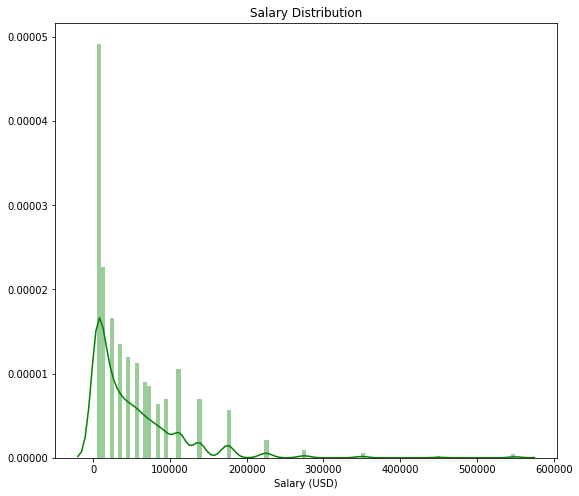

In [53]:
plt.figure(figsize=(9, 8))
sns.distplot(Salaries_df['Q9'], color='g', bins=100, hist_kws={'alpha': 0.4});
plt.xlabel('Salary (USD)')
plt.title('Salary Distribution')

### 2.1.2 Salary variation for different experience levels

In all the further cases, the data is shown seperately for males and females since 85% of the data available was for males as discussed a bit later.

In [54]:
#This will be used in the later sections as well
#Seperate male and female into different dataframe
males = Salaries_df[Salaries_df['Q1']== "Male"]
females = Salaries_df[Salaries_df['Q1']== "Female"]

#Turn the income dataframe into float type
male_income = males['Q9'].astype(float)
female_income = females['Q9'].astype(float)

<Figure size 432x288 with 0 Axes>

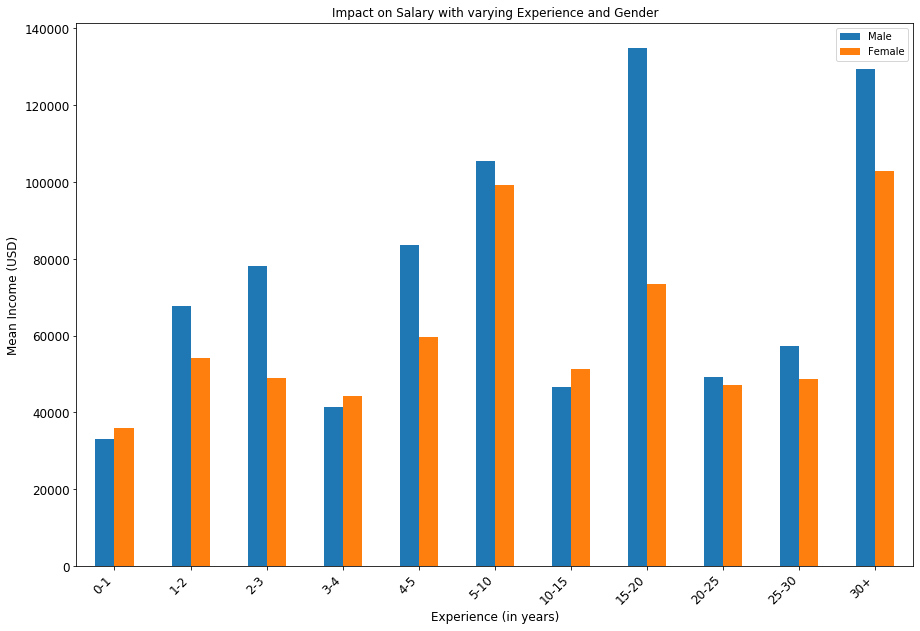

In [55]:
#Get the experience level of male and female
male_exp = males['Q8']
female_exp = females['Q8']

#Combine experience level and income into a dataframe
male = pd.concat([male_exp, male_income], axis = 1)
female = pd.concat([female_exp, female_income], axis = 1)

#Calculate mean income of different age group
male_mean = male.groupby('Q8').mean()
female_mean = female.groupby('Q8').mean()
total_mean = pd.concat([male_mean, female_mean], axis = 1, sort=True)

#Plotting the bar graph
plt.clf()
plot = total_mean.plot.bar(title ="Impact on Salary with varying Experience and Gender",figsize=(15,10), fontsize=12)
#changing the age labels back in to the original format
exp = ('0-1', '1-2', '2-3', '3-4', '4-5', '5-10', '10-15','15-20','20-25','25-30','30+')
y_pos = np.arange(len(total_mean))
plt.xticks(y_pos, exp, color='black', rotation=45, fontsize='12', horizontalalignment='right')

plt.legend(['Male','Female'])
plt.xlabel("Experience (in years)",fontsize=12)
plt.ylabel("Mean Income (USD)",fontsize=12)
plt.show()

As expected, there was a variation of salary with changing experience level and gender. There is no direct proportional increase between the experience and mean income. This can because the data available for the experience range of 20-30 years is sparse.
It is also important to note the amount of data available for male and female are different. Almost, 85% of the data is for Male whereas only 15% of the data belongs to females.


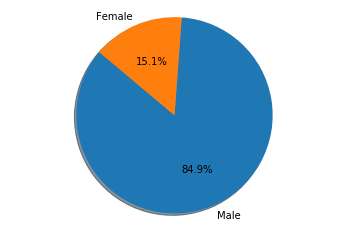

In [56]:
plt.pie([male.shape[0],female.shape[0]], labels= ["Male","Female"],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

### 2.1.3 Impact of job title on the Salary

<Figure size 432x288 with 0 Axes>

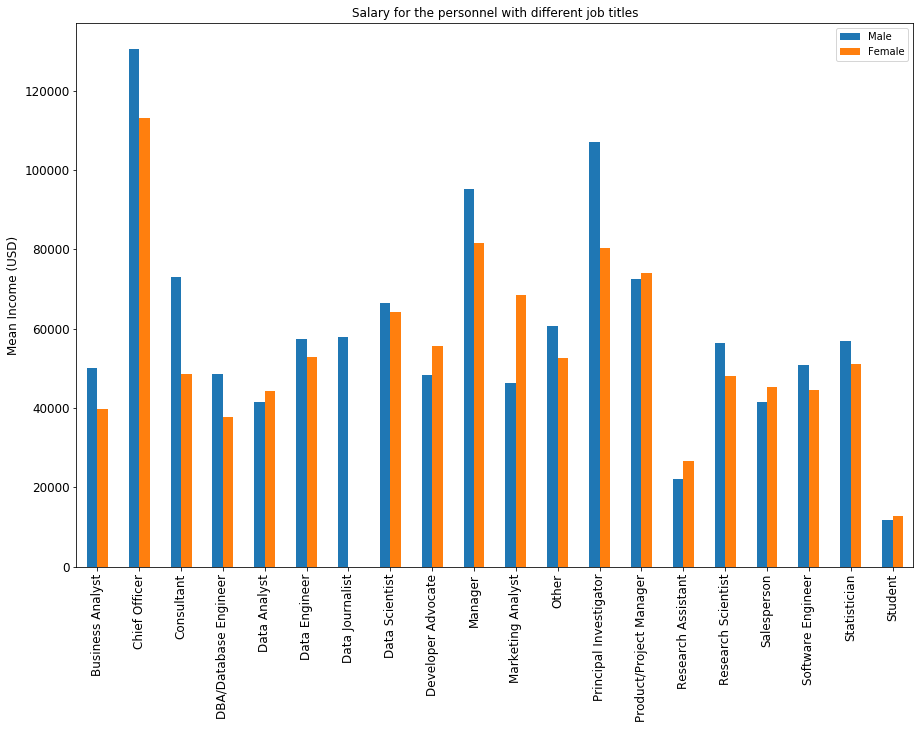

In [57]:
#Get the job title of males and females
male_title = males['Q6']
female_title = females['Q6']

#Combine undergrad major and income into a dataframe
male = pd.concat([male_title, male_income], axis = 1)
female = pd.concat([female_title, female_income], axis = 1)

#Calculate mean income of different age group
male_mean = male.groupby('Q6').mean()
female_mean = female.groupby('Q6').mean()
total_mean = pd.concat([male_mean, female_mean], axis = 1, sort=True)

#Plotting the bar graph
plt.clf()
plot = total_mean.plot.bar(title ="Salary for the personnel with different job titles",figsize=(15,10), fontsize=12)

y_pos = np.arange(len(total_mean))

plt.legend(['Male','Female'])
plt.ylabel("Mean Income (USD)",fontsize=12)
plt.show()

There is a noticeable variation of salary for different job titles. Chief officer tends to have a higher income than a Student which is also what would be expected.
These would represent important features when predicting the salary classes. Again, the difference between males and females can be seen from the same chart.

### 2.1.4 Impact of Coutries on Salary

<Figure size 432x288 with 0 Axes>

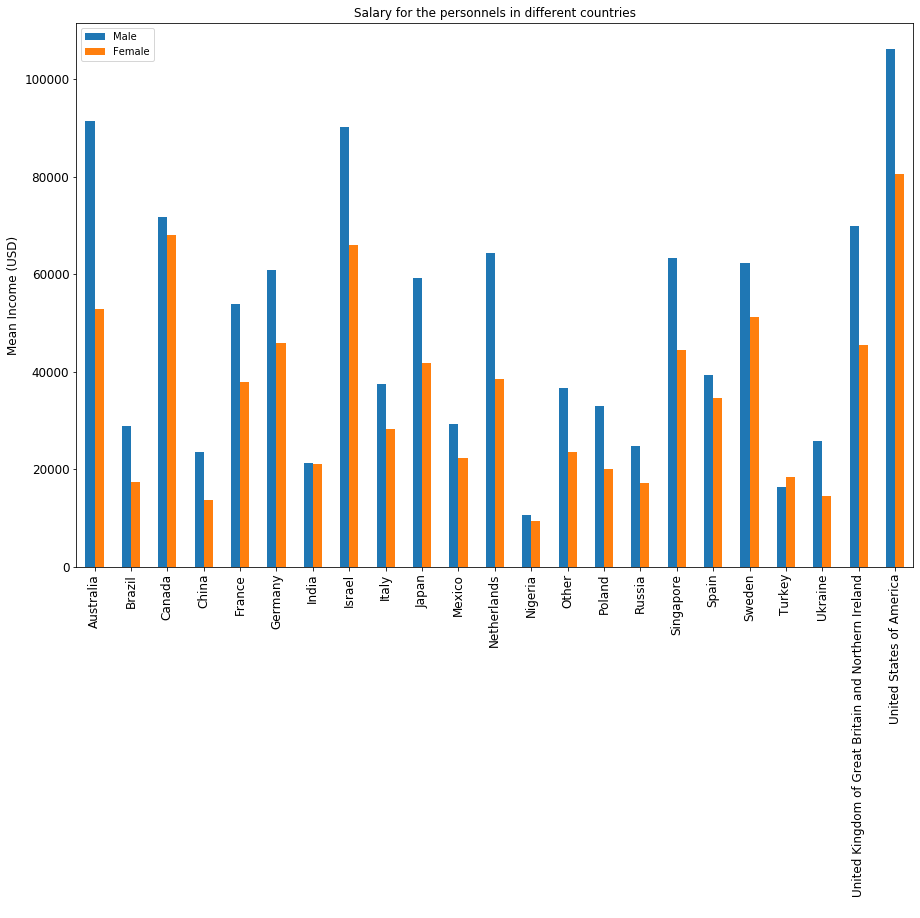

In [58]:
#Get the countries of males and females
male_country = males['Q3']
female_country = females['Q3']

#Combine undergrad major and income into a dataframe
male = pd.concat([male_country, male_income], axis = 1)
female = pd.concat([female_country, female_income], axis = 1)

#Calculate mean income of different age group
male_mean = male.groupby('Q3').mean()
female_mean = female.groupby('Q3').mean()
total_mean = pd.concat([male_mean, female_mean], axis = 1, sort=True)

#Plotting the bar graph
plt.clf()
plot = total_mean.plot.bar(title ="Salary for the personnels in different countries",figsize=(15,10), fontsize=12)

y_pos = np.arange(len(total_mean))
plt.legend(['Male','Female'])
plt.ylabel("Mean Income (USD)",fontsize=12)
plt.xlabel(" ")
plt.show()

Salary also tends to vary with the different countries. USA for example has a much higher salary compared to Nigeria for example. These classification would help in determining the expected salary bracket for the individual.

### 2.2 Feature Importance

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Here, we use Mutual Information.

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

MI will deal with the data without making it dense and hence it was preferred over other models such as Random Forrest Classifier.

In [59]:
#Apply mutual info classification to target veriables and features
feat_imp = pd.DataFrame()
feat_imp['Feature'] = data.columns
feat_imp['MI'] = mutual_info_classif(data,Salaries_df['Q9'])

Since the features are one-hot encoded, the mutual information plot shows the affect of each field within the feature to its target. The reason the main features (not encoded) data was not used because I wanted to show the affect of my specific features that would be used to train the Logistic Regression model.

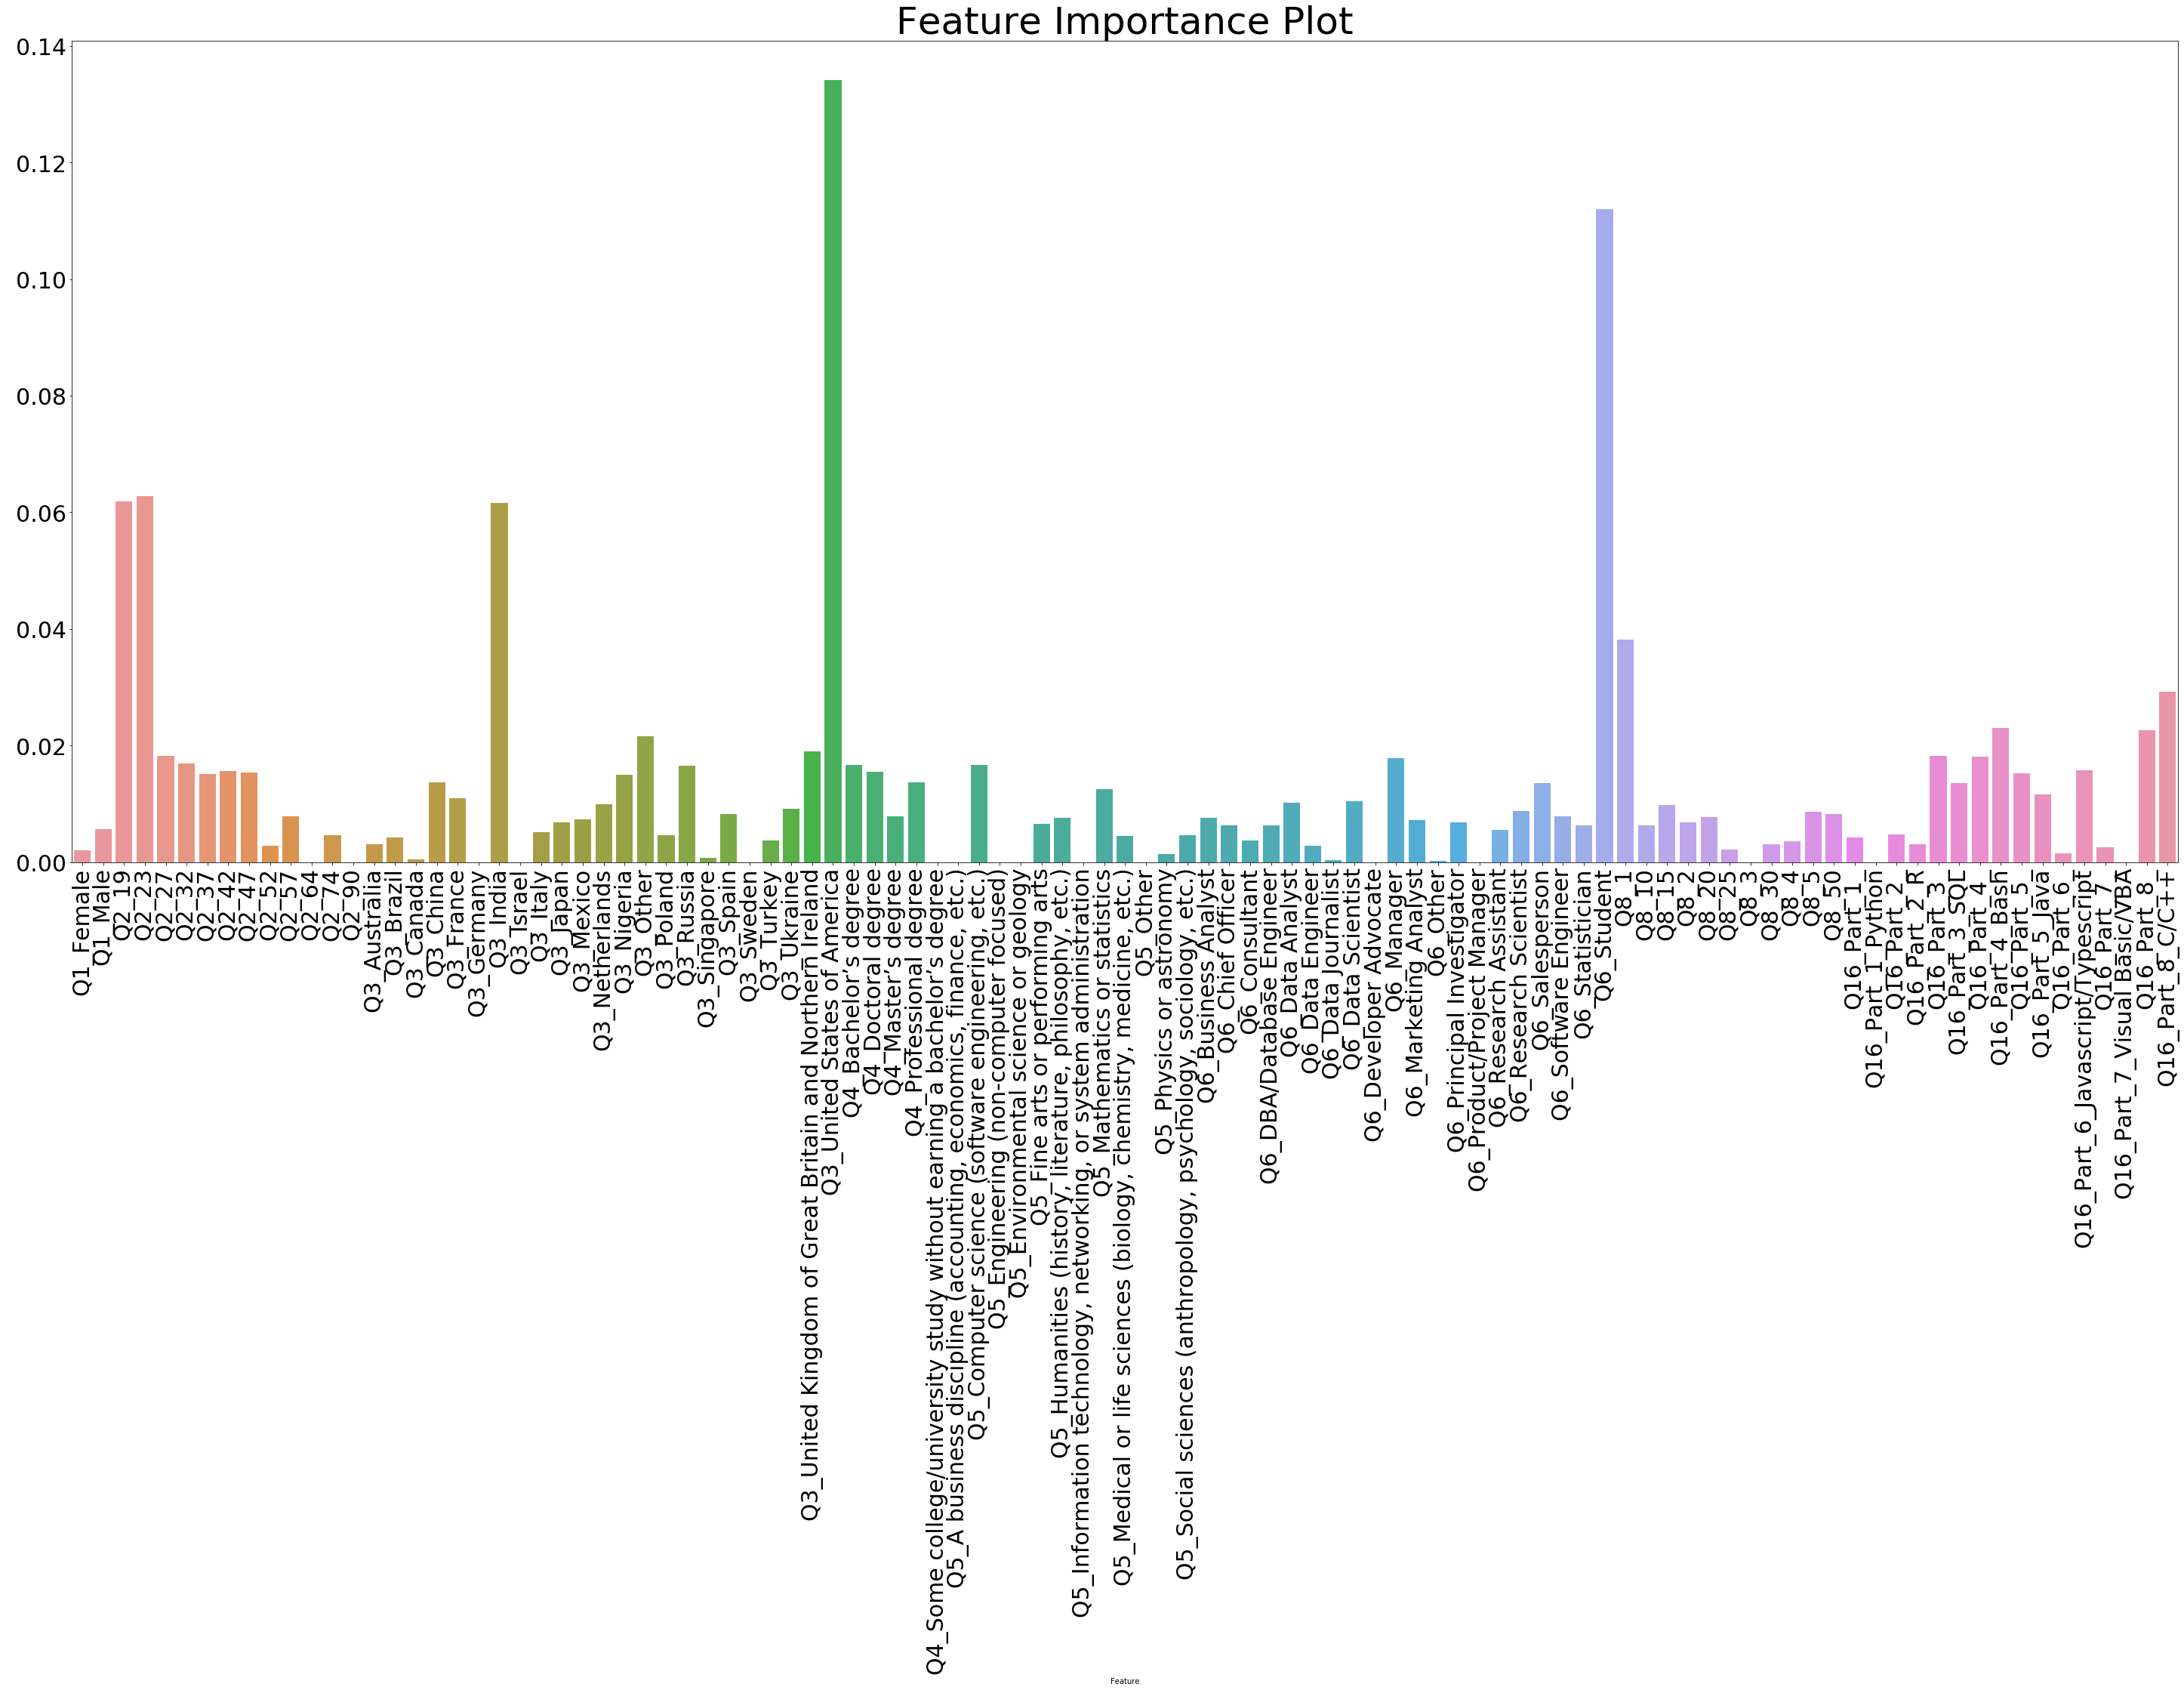

In [60]:
#Plot MI against all features
plt.figure(figsize = (50,20))
ax = sns.barplot(data = feat_imp.reset_index(), x = 'Feature', y = 'MI')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=30)
ax.yaxis.set_tick_params(labelsize=30)
plt.title("Feature Importance Plot", size=50)
plt.ylabel(" ")
for item in ax.get_xticklabels():
    item.set_rotation(90)

As seen from the plots earlier, the different features selected does have an impact on the salary (which is the target).
Its also interesting to see how the U.S.A (in countries) and Student (in Job title) seems to be having the highest impact.

It can also be seen that there are some features which are showing little to no impact, and it will be seen that these features will be eliminated in the next section

## 3- Feature Selection

Data in the real world can be extremely messy and chaotic. Feature engineering is a process of transforming the given data into a form which is easier to interpret. Features can not only be selected but some features can be generated so that the data visualization prepared for people without a data-related background can be more digestible.

Having and engineering good features will allow you to most accurately represent the underlying structure of the data and therefore create the best model. 
Feature selection reduces the computation time and resources needed to create models as well as preventing overfitting which would degrade the performance of the model. The flexibility of good features allows less complex models, which would be faster to run and easier to understand, to produce comparable results to the complex ones.

The feature selection technique used in this case is Lasso Regression.

Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models.

On the other hand, L2 regularization (e.g. Ridge regression) doesn’t result in elimination of coefficients or sparse models. This makes the Lasso far easier to interpret than the Ridge and hence it was used in this case.

In [61]:
#warnings are being ignored since there will be a lot of these coming up in the later sections
import warnings
warnings.simplefilter(action='ignore')

In [62]:
predictors= data.copy()
tar = Salaries_df.Q9.copy()
predictors.shape

(12797, 101)

Before the Lasso, there are 101 features. The function being used here is actually the Cross-validated Lasso, using the LARS algorithm. This is Lasso based on the Least angle regression algorithm. LARS is an algorithm for fitting linear regression models to high-dimensional data.

Note that this will be cross-validated to get the best alpha parameter.

P.S. This produced better results than the Lasso itself. The best model has been kept for the assignment.

In [63]:
#The best alpha parameter is selected by cross-validation
model = LassoLarsCV(cv=10, precompute=False).fit(predictors, tar)

Now that the Lasso is run, lets try to visualize the results.

In [64]:
var_imp = pd.DataFrame(data = {'predictors':list(predictors.columns.values),'coefficients':model.coef_})
var_imp['sort'] = var_imp.coefficients.abs()
#Displaying the result for all the features with the corresponding coefficients 
display(var_imp.sort_values(by='sort', ascending=False))

,predictors,coefficients,sort
13,Q2_90,-77971.632768,77971.632768
55,Q6_Chief Officer,58183.949989,58183.949989
36,Q3_United States of America,57278.310699,57278.310699
14,Q3_Australia,39347.937930,39347.937930
84,Q8_50,38861.178191,38861.178191
21,Q3_Israel,36464.797355,36464.797355
81,Q8_30,29224.409856,29224.409856
10,Q2_57,27436.368798,27436.368798
16,Q3_Canada,27365.126731,27365.126731
73,Q6_Student,-24399.739421,24399.739421


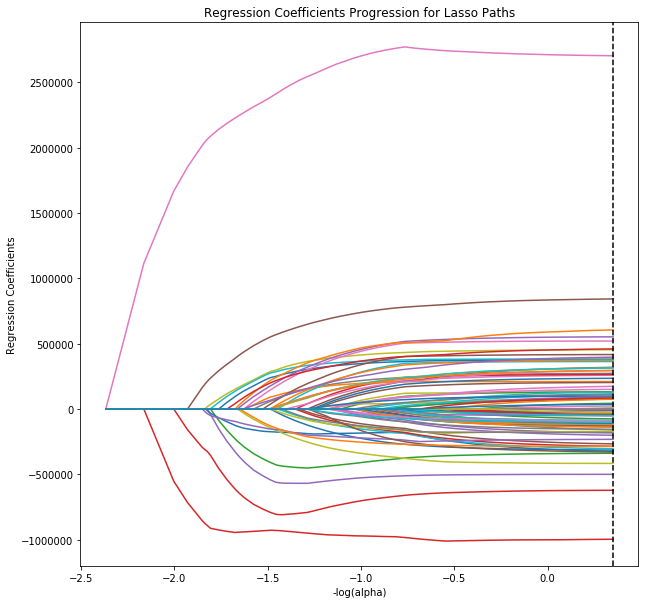

In [65]:
# plot coefficient progression plot for all the features for visualization
plt.figure(figsize = (10,10))
m_log_alphas = -np.log10(model.alphas_)
ax = plt.gca()
plt.plot(m_log_alphas, model.coef_path_.T)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')
plt.show()

There are 13 features that have zero coefficient. These will be removed from the original dataset.

In [66]:
#Removing the zero co-efficients features
temp= []
for index, values in enumerate(var_imp.sort.values):
    if values ==0:
        temp.append(var_imp.predictors[index])        

In [67]:
# Selecting the features whose coefficients are not zero
data= data.drop(data[temp], axis=1)
data.shape

(12797, 88)

Principle Component Analysis is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible.

However, when I used PCA for my model, the accuracy of the regression was not affected (this code was not included in this notebook). I looked into why that happened.

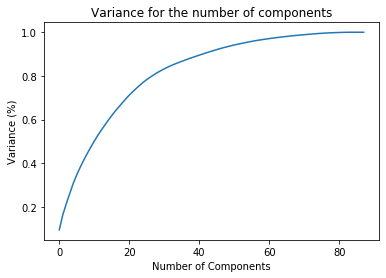

In [68]:
from sklearn.decomposition import PCA
pca= PCA().fit(data)

#plotting the variance for the different components
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")
plt.title("Variance for the number of components")
plt.show()

It is important to note that I did not have a lot of features to begin with before utilizing the PCA. It was around 88.

As it can be seen from the above plot, approximately 80% of variance is explained by 60+ components. So removing the rest would not make an impactful difference in the results. 
If I remove more features, I would lose the variance of my dataset and the model would actually perform worse.

PCA could have potentially produced better results in case I had a lot of features and hence it was not implemented in this model.

## 4- Model Implementation

 Logistic Regression is a supervised machine learning algorithm used in binary classification (usually). We will discuss how it can be implemented for multi-class classificaiton later on.
 
Pros: 
- easy to interpret. the output can be interpreted as a probability: you can use it for ranking instead of classification.
- good for cases where features are expected to be roughly linear, and the problem to be linearly separable.
- can easily "feature engineering" most non-linear features into linear ones.
- robust to noise
- can use l2 or l1 regularization to avoid overfitting(and for feature selection)

Cons:
- Can't solve non-linear problems
- It is not a useful tool unless you have already identified all the important independent variables. Since its outcome is discrete, Logistic Regression can only predict a categorical outcome.
- It is also an Algorithm that is known for its vulnerability to overfitting.

The model implementation was performed various number of times but only the final product is shown here.

As part of the learnings, the model (both Logistic Regression and OneVsRest Classifier) produced poor accuracy when the model was asked to predict all 18 salary brackets (as per the original dataset). This was understood to be because the higher salary scales did not have enough data. As discussed earlier, the data is skewed to the right and most of the data that the model is being trained on is in either the 0-10k, 10k-20k or 20k-30k bracket (almost 50% of the data). This caused the model unable to predict the higher salary classes. The highest accuracy achieved with all the brackets was approximately 40%.

The approach taken here is to seperate the salaries into 4 classes and see how the model performs (done earlier). It is important to understand that this means the model will be able to predict less in terms of the exact salary bracket but it will be more accurate as the results will indicate.

### 4.1 Model implementation using Logistic Regression

In [69]:
X= data.copy()
y= target.copy()

In [70]:
#Splitting the dataset into train and test (1/3rd of data is test)
X_train, X_test, y_train, y_test  = train_test_split(X, y , test_size=0.33, random_state=13)

The idea behind Standard Scaler is that it will transform the data, such that the distribution will have a mean value of 0 and a standard deviation of 1. Scaling does not increase accuracy but it is a good idea so that a large numerical value does not overwhelm a smaller one.

In [71]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic regression is one of the most popular supervised classification algorithm. This classification algorithm mostly used for solving binary classification problems. However, Logistic regression algorithm can also use to solve the multi-classification problems.

P.S. Running the Logistic Regression without defining the multi_class gave similar results. However, since this is a multi-classification problem, the multinomial logistic regression was used. The solver was defined because the default, which is liblinear will not work in this case. multi_class='multinomial' works only for the newton-cg, sag and lbfgs solvers.

In [72]:
model = LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
predictions = model.predict(X_test)
    
ACC = accuracy_score(y_test, predictions)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 67.12% on the testing set


Let's do some model tuning by changing parameters

In [74]:
model = LogisticRegression(multi_class= 'multinomial', C=10, solver= "sag")
model.fit(X_train, y_train)

predictions = model.predict(X_test)
ACC = accuracy_score(y_test, predictions)
print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 67.12% on the testing set


In [75]:
model = LogisticRegression(multi_class= 'multinomial', C=5, solver= "lbfgs")
model.fit(X_train, y_train)

predictions = model.predict(X_test)
ACC = accuracy_score(y_test, predictions)
print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 67.19% on the testing set


Changing the hyperparameters does not seem to have a large impact on the accuracy. This will be further explored in Section 5.

Running the same model with 10-folds cross-validation

In [76]:
model = LogisticRegression(multi_class= 'multinomial', solver= "newton-cg")
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(data):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = target.values[train_idx], target.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    ACC= accuracy_score(y_test, predictions)*100
    accuracy[np_idx] = ACC
    np_idx += 1

    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 75.391%
Fold 2: Accuracy: 64.688%
Fold 3: Accuracy: 63.203%
Fold 4: Accuracy: 63.125%
Fold 5: Accuracy: 72.891%
Fold 6: Accuracy: 64.531%
Fold 7: Accuracy: 64.531%
Fold 8: Accuracy: 67.709%
Fold 9: Accuracy: 68.491%
Fold 10: Accuracy: 71.775%
Average Score: 67.633%(4.166%)


This is a good accuracy across the 10-folds. Lets see how it performs for different training sets.

plot_learning_curve() uses in turn the function sklearn.learning_curve.learning_curve(), which determines cross-validated training and test scores for different training set sizes. An (optional) cross-validation generator splits the given dataset k times in training and test data. (The default is 3-fold cross validation.) Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. The scores are averaged over all k runs for each training subset size.

In [77]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score (Cross validation)")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\syedh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

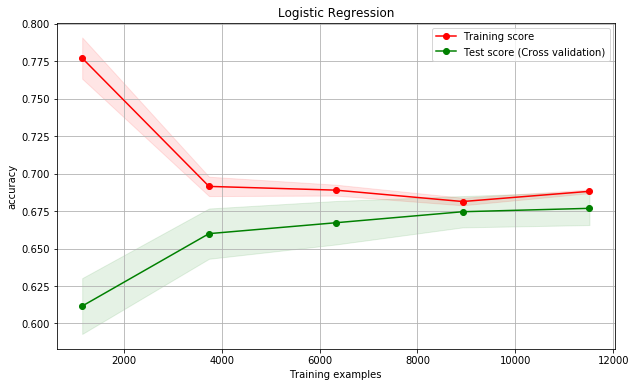

In [78]:
plot_learning_curve(model,'Logistic Regression', X, y, cv=10)

The results indicate that the training and cross-validated (test) scores match up nicely with the training error being higher which is as it should be for a good model.
If the training error was lower than the test model, it could have reprsented an overfit model. If both the accuracies were low, it could have represented an underfit model.

The above has only been dealing accuracy. Now lets visualize our predictions and see how they match up with the actual values.

In [79]:
#defining predictions and actual (which is y_test) as dataframes and combining them into one
pred= pd.DataFrame(predictions, columns= ["Predicted Salary Class"])
y_t = pd.DataFrame(y_test, columns= ["Actual Salary Class"])

comparisons= pd.concat([pred,y_t], axis=1)

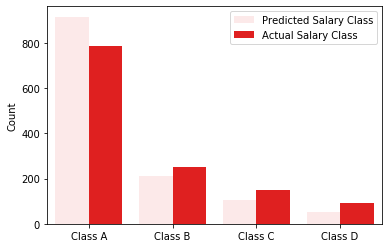

In [80]:
#Plotting the results
sns.countplot(x="value", hue="variable", color = "red", data=pd.melt(comparisons))
plt.xlabel("")
plt.ylabel("Count")
plt.legend(["Predicted Salary Class","Actual Salary Class"])
plt.show()

We can clearly see that most of Class A got predicted correctly. This is expected since majority of data was available for Class A. The model has basically taken the predictions of other Classes and assigned it to Class A.

This is not a good method of seeing how good the model was. Lets have a look at the confusion matrix.

In [81]:
#defining the confusion matrix
cm = confusion_matrix(predictions,y_test, labels= y.cat.categories)

In [82]:
cmDF = pd.DataFrame()

for i, row in enumerate(y.cat.categories):
    temp = {}
    for j, col in enumerate(y.cat.categories): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

print(cmDF)

         Class A  Class B  Class C  Class D
Class A      734      114       40       27
Class B       38      106       49       17
Class C       10       29       47       17
Class D        2        4       14       31


Lets visualize the numbers shown above.

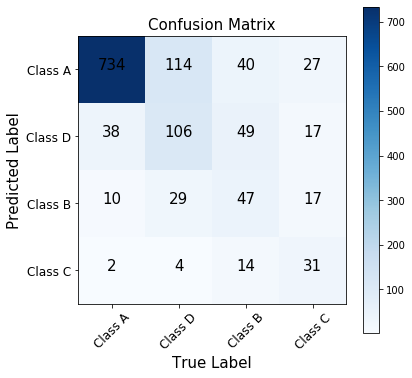

In [83]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(y.unique()))
plt.xticks(tick_marks, y.unique(), rotation=45, fontsize=12)
plt.yticks(tick_marks, y.unique(), fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] < 0:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)


The confusion matrix clearly shows that most of the cases were Class A. However, it can be seen clearly seen that so many of the Class D casees were predicted as Class A.
The model has struggled with predicting salary brackets that were sparse in numbers.

Other metrics such as recall, precision were not calculated for this case. These terms are important to understand to study the model's results, since accuarcy standalone is not a good enough measure. However, these terms are not well-defined in the multi-class case. Typically, we need to use one vs. all style classifiers so that the model is fitted with one class as the positive class and the remainder as the negative class (this is done in the next section).

## 4.2 Model Implementation using OneVsRest Classifier

The OneVsRest strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

This method will be used to calculate the other metrics, mainly the ROC curve. In addition, we will see how this model performs against the one in the earlier section.

In [84]:
#need to binarize the target before using the OneVsRest
bin_y = label_binarize(target, classes=target.cat.categories)
X= data.copy()
y= pd.DataFrame(bin_y, columns= ["Class A", "Class B", "Class C", "Class D"])

The same exercise is repeated as in Section 4.1

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [86]:
model = OneVsRestClassifier(LogisticRegression())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [87]:
predictions = model.predict(X_test)
    
ACC = accuracy_score(y_test, predictions)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))   

This model got an accuracy of 50.68% on the testing set


In [88]:
model = OneVsRestClassifier(LogisticRegression())
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(data):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    ACC= accuracy_score(y_test, predictions)*100
    accuracy[np_idx] = ACC
    np_idx += 1

    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 64.531%
Fold 2: Accuracy: 47.578%
Fold 3: Accuracy: 43.516%
Fold 4: Accuracy: 43.984%
Fold 5: Accuracy: 60.078%
Fold 6: Accuracy: 47.578%
Fold 7: Accuracy: 46.25%
Fold 8: Accuracy: 49.961%
Fold 9: Accuracy: 53.245%
Fold 10: Accuracy: 58.874%
Average Score: 51.56%(6.941%)


The accuracy is lower compared to the model used in Section 4.1.
OneVsRest classifier is typically used to get the prediction probabilities for all classes, and find FPR (False Positive Rate), TPR (True Positive Rate), and AUC (Area Under Curve) for each class. 
This was an exercise to just see how the model performs.

In [89]:
y_score = model.decision_function(X_test)

In [90]:
TPR, FPR, AUC = {}, {}, {}

for i in range(len(target.cat.categories)):
    FPR[i], TPR[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    AUC[i] = auc(FPR[i], TPR[i])

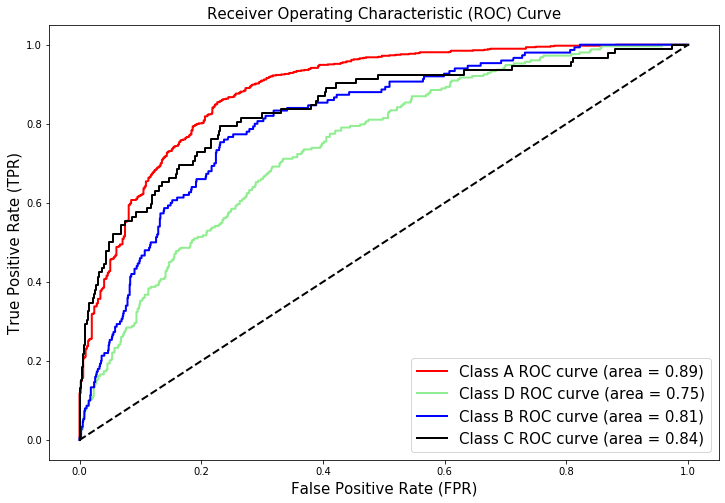

In [91]:
plt.figure(figsize=(12,8))
colors = ['red','lightgreen','blue', 'black']
for i in range(len(target.unique())):
    plt.plot(FPR[i], TPR[i], color=colors[i], lw=2, label='%s ROC curve (area = %0.2f)' % (target.unique()[i],AUC[i]))

plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=15)
plt.ylabel('True Positive Rate (TPR)', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc=4, fontsize=15)

Each point on the ROC curve represents a TPR/FPR pair that correspond to a particular decision threshold. The best possible curve is one for Class A since its on the most far left of the plot. The Class D is the worst as expected.

The black dashed line represents the worst possible model. It is equivalent to randomly assigning TP/FP. 
This is useful for evaluating multiple models against one another, either directly are at various TPR/FPR thresholds. The AUC can be seen as a summary of the model's ability like the F1-score. 

## 5- Model Tuning

## 5.1 Grid Search

This model tuning exercise will be done to find the best combination of parameters which can be treated as a search problem.
There are other techniques available to do this, such as Random Search, however, we will be exploring by using Grid Search. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

Note: Accuracy, precision and recall has been discussed for the model in Section 4. Even though the Assignment notes mentions it in this section, I understood it would make more sense for it to be discussed alongside the model implementation. Also, we will be tuning the Logistic Regression model only since it gave better results (Section 4.1)

In [92]:
X= data.copy()
y= target.copy()

In [93]:
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = None
best_params = {}
best_accuracy = 0
best_std = 0

#2 hyperparameters being tuned here- C and solver

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','sag']:
        
        model = LogisticRegression(multi_class= 'multinomial', C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = target.values[train_idx], target.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            ACC=model.score(X_test,y_test)*100
            accuracy[np_idx] = ACC
            np_idx += 1

            
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.05, 'solver': 'lbfgs'}
Best Score: 67.657%(4.064%)

The optimal log model uses C=0.05, and a lbfgs solver, and has a cross validation score of 67.657% with a standard deviation of 4.064%


Result from the grid search (since it takes a long time to run):

{'C': 1, 'solver': 'newton-cg'}
Best Score: 66.75%(4.247%)

The optimal log model uses C=1, and a newton-cg solver, and has a cross validation score of 66.75% with a standard deviation of 4.247%

The grid search did not increase the accuracy greatly. However, this is a good exercise to ensure the best possible model is obtained depending on the different hyperparameters.
This model will now be used for the final section.

## 5.2 Bias vs Variance Trade-off

The bias–variance tradeoff is the property of a set of predictive models whereby models with a lower bias in parameter estimation have a higher variance of the parameter estimates across samples, and vice versa.

This is an important feature of ML models; it is a tough task to find the right balance between the two. We explore the following below.

In [94]:
#Mean Squared error is calculated for multinomial models with various C values and different solver to find the best model

scaler = StandardScaler()
testErr= []
trainErr= []

#Label encoding is performed to the target since the mean_squared_error does not work with categorical variables
le= LabelEncoder()
y= le.fit(y).transform(y)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','sag']:
        
        model = LogisticRegression(multi_class= 'multinomial', C=C, solver=solver)
        
        model.fit(X_train, y_train)
        
        y_train_pred= model.predict(X_train)
        y_test_pred= model.predict(X_test)
               
        trainErr.append(mean_squared_error(y_train, y_train_pred))
        testErr.append(mean_squared_error(y_test, y_test_pred))      

In [95]:
#Creating dataframe of the results for the training data
df_train= pd.DataFrame(np.array(trainErr).reshape(9,3), columns= ["newton-cg", "lbfgs", "sag"])
df_train['average'] = df_train.mean(numeric_only=True, axis=1)
df_train.index = df_train.index.map(str)
df_train.index= ['C=0.001', 'C=0.01','C=0.05','C=0.1','C=0.5','C=1','C=5','C=10','C=100']
df_train

,newton-cg,lbfgs,sag,average
C=0.001,0.796584,0.796584,0.796584,0.796584
C=0.01,0.678464,0.678464,0.678464,0.678464
C=0.05,0.657140,0.657140,0.657698,0.657326
C=0.1,0.653790,0.653790,0.654795,0.654125
C=0.5,0.648766,0.648766,0.652004,0.649846
C=1,0.647762,0.648096,0.651446,0.649101
C=5,0.647092,0.647092,0.651669,0.648617
C=10,0.647092,0.647092,0.651669,0.648617
C=100,0.647092,0.647203,0.651669,0.648655


In [96]:
#Creating dataframe of the results for the test data
df_test= pd.DataFrame(np.array(testErr).reshape(9,3), columns= ["newton-cg", "lbfgs", "sag"])
#Adding an average column for all the methods
df_test['average'] = df_test.mean(numeric_only=True, axis=1)
#Replacing index with values of C
df_test.index = df_test.index.map(str)
df_test.index= ['C=0.001', 'C=0.01','C=0.05','C=0.1','C=0.5','C=1','C=5','C=10','C=100']
df_test

,newton-cg,lbfgs,sag,average
C=0.001,0.822135,0.822135,0.822135,0.822135
C=0.01,0.741667,0.741667,0.741667,0.741667
C=0.05,0.715885,0.714844,0.715625,0.715451
C=0.1,0.715625,0.715625,0.710677,0.713976
C=0.5,0.709375,0.709375,0.708073,0.708941
C=1,0.708854,0.708854,0.708073,0.708594
C=5,0.707812,0.707812,0.709115,0.708247
C=10,0.708073,0.708073,0.706771,0.707639
C=100,0.708073,0.708073,0.706771,0.707639


In [97]:
#Combing the average errors of the training and test data
df_error= pd.concat([df_train["average"], df_test["average"]], axis=1, join='inner')
df_error.columns= ["Training Error","Test Error"]

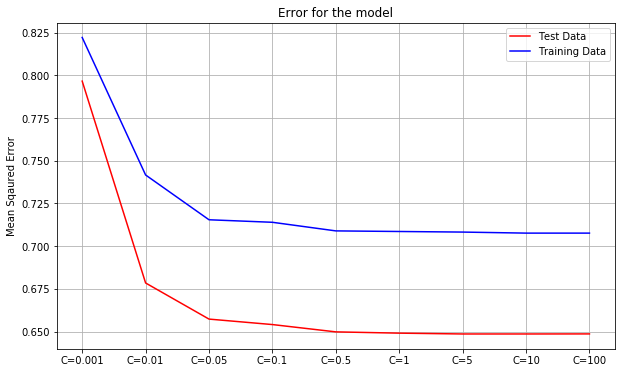

In [98]:
#Plotting the two errors
plt.figure(figsize=(10, 6))
           
plt.plot(df_error["Training Error"], 'r')
plt.plot(df_error["Test Error"], 'b')
plt.ylabel("Mean Sqaured Error")
plt.xlabel("")
plt.title("Error for the model")
plt.legend(['Test Data','Training Data'])
plt.grid()

plt.show()

When fitting a model you are trying to minimize your bias, and variance. You minimize your bias, by minimizing your training error. You minimize your variance my reducing the difference between your training and testing error.

In our case, the difference between the training and test error is not great. However, the bias is high since the training error itself is quite high. This is understood and expected given the bias in the data for the lower salary classes.

Note: Log-loss error function is used for Logistic Regression whereas Mean Squared Error is used for Linear Regression. However, since log-loss method was not working for this case, I decided to use the MSE to explain the variance and bias trade-off. It was also done in the Tutorial 4.

## 6- Testing & Discussion

Using the best model parameters obtained from Grid Seach and using it on the test data

In [99]:
X= data.copy()
y= target.copy()

model = LogisticRegression(multi_class= 'multinomial', C= 1, solver= 'newton-cg') #this is specified since the grid search takes a long time to run and makes it tough to do multiple trials quickly

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13) 

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predictions_training = model.predict(X_train)
predictions= model.predict(X_test)


ACC_training= accuracy_score(y_train, predictions_training)
ACC = accuracy_score(y_test, predictions)

print ("This model got an accuracy of {}% on the training set".format(round(ACC_training*100,2)))   
print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

This model got an accuracy of 69.12% on the training set
This model got an accuracy of 66.95% on the testing set


The final distribution of the salaries will be shown the same way it was represented in the Section 4.1. The predictions are plotted to see the distribution and the comparison with the actual classes.

In [100]:
#defining predictions and actual (which is y_test) as dataframes and combining them into one
pred= pd.DataFrame(predictions, columns= ["Predicted Salary Class"])
y_t = pd.DataFrame(y_test)
y_t.reset_index(drop=True, inplace=True)

comparisons= pd.concat([pred,y_t], axis=1)

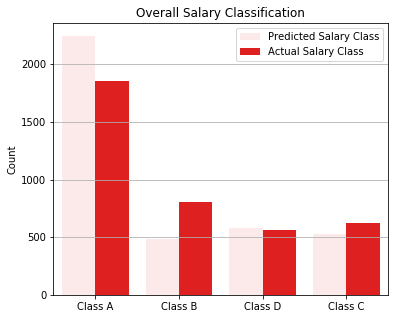

In [101]:
#Plotting the results
plt.figure(figsize=(6,5))
plt.grid()
sns.countplot(x="value", hue="variable", color = "red", data=pd.melt(comparisons))
plt.xlabel("")
plt.ylabel("Count")
plt.title("Overall Salary Classification")
plt.legend(["Predicted Salary Class","Actual Salary Class"])
plt.show()

As can be seen, this bar chart looks a bit different to the one shown in Section 4.1. There is much better overall classification for all the classes. Specially the higher classes which has been a struggle to achieve in this model. The model suggested by Grid Search may not have resulted in a higher accuracy but it has helped achieve more correct predictions for the higher classses.

For the final task, the probabilty distribution is shown for one of the features to see which salary class the person could belong to given the features.

In [102]:
prob= model.predict_proba(X_test)
df_prob= pd.DataFrame(prob, columns= ["Probability of being in Class A", "Probability of being in Class B", "Probability of being in Class C", "Probability of being in Class D" ])
df_prob.head()

,Probability of being in Class A,Probability of being in Class B,Probability of being in Class C,Probability of being in Class D
0,0.864935,0.092454,0.037205,0.005406
1,0.809211,0.138729,0.048264,0.003797
2,0.314972,0.332944,0.239689,0.112395
3,0.815143,0.126641,0.038660,0.019555
4,0.449140,0.264313,0.104112,0.182435


The actual Salary Class for the person is Class C


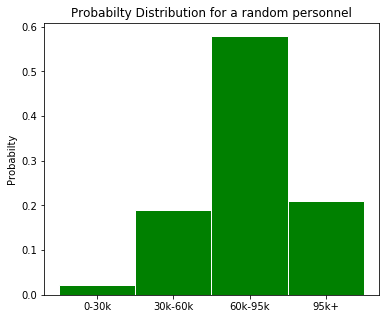

In [103]:
#Lets plot of probability distribution for one person
index= 49 #chosen at random
#resetting index so the actual salary bracket can be called
y_test.reset_index(drop=True, inplace=True)
print("The actual Salary Class for the person is", y_test[index])

plt.figure(figsize= (6,5))
#Salary Classes replaced with the actual brackets
plt.bar(["0-30k", "30k-60k","60k-95k","95k+"] ,list(df_prob.iloc[index,:]),facecolor='green', edgecolor='white', width=1)
plt.ylabel("Probabilty")
plt.title("Probabilty Distribution for a random personnel")
plt.show()

### Discussion and Conclusion

There were two models implemented to classify the salary brackets.
- Logistic Regression model: The accuracy after the grid search was approximately 68%. The confusion matrix indicated how the higher salary ranges were not being classified as well as the lower salary ranges. This is expected since the majority of the data that the model was trained upon was consisting of the lower salary classes.
- OneVsRest Classifier: The accuracy from the model was lower, however, it helped us obtaining the values for the other performance metrics in the form of the ROC curve. Again, it indicated that Class D showed the worst classification results.

The salaries were divided into 4 brackets so that the model could be more accurate in predicting the salary classes. It is understood that dividing them would mean that the model will not be able to predict the exact salary classes (as per original dataset). This is because the 18 salary brackets are not distributed evenly and there is a huge bias towards the lower salary classes. The only way to remedy the situation was to group the salary brackets. This exercise could be done further to increase the number of salary brackets- this would help classify more classes but at the cost of decreasing accuracy.